## NERC Project for Recognizing and Classifying Drugs

In [1]:
import sys
import string
from os import listdir
from xml.dom.minidom import parse
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)

### Tokenize Sentence

In [3]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/zosia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zosia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Sentence examples
sent_1 = "Activation of an effector immediate-early gene arc by methamphetamine"
sent_2 = "In situations in which concurrent therapy is necessary, careful patient monitoring is essential."
sent_3 = "Phenothiazines and butyrophenones may reduce or reverse the depressor effect of epinephrine."

In [5]:
# Tokenize word
tokenized_sent_1 = word_tokenize(sent_1)
tokenized_sent_2 = word_tokenize(sent_2)
tokenized_sent_3 = word_tokenize(sent_3)
print(tokenized_sent_3)

['Phenothiazines', 'and', 'butyrophenones', 'may', 'reduce', 'or', 'reverse', 'the', 'depressor', 'effect', 'of', 'epinephrine', '.']


In [6]:
# Use the .find() method to find offset and end position
print("OffsetFrom: " + str(sent_3.find(tokenized_sent_3[0]))) # offset
print("OffsetTo: " + str(sent_3.find(tokenized_sent_3[0]) + len(tokenized_sent_3[0]) - 1)) # end
print("")
print("OffsetFrom: " + str(sent_2.find(tokenized_sent_2[1]))) # offset
print("OffsetTo: " + str(sent_2.find(tokenized_sent_2[1]) + len(tokenized_sent_2[1]) - 1)) # end

# From this results generate desired output: list of tuples (word, offsetFrom, offsetTo)

OffsetFrom: 0
OffsetTo: 13

OffsetFrom: 3
OffsetTo: 12


In [7]:
# Removing Stopwords and Punctuations to Reduce Workload
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

filtered_sent = []

for w in tokenized_sent_3:
    if (w not in stop_words) & (w.isalpha()):
        filtered_sent.append(w)

print("Tokenized Sentence:",tokenized_sent_3)
print("Filterd Sentence:",filtered_sent)

Tokenized Sentence: ['Phenothiazines', 'and', 'butyrophenones', 'may', 'reduce', 'or', 'reverse', 'the', 'depressor', 'effect', 'of', 'epinephrine', '.']
Filterd Sentence: ['Phenothiazines', 'butyrophenones', 'may', 'reduce', 'reverse', 'depressor', 'effect', 'epinephrine']


In [8]:
def tokenize(s):
    '''
    Given a sentence , calls nltk.tokenize to split it in tokens, and adds to each token its start / end offset 
    in the original sentence .
    Input - s: string containing the text for one sentence
    Output - Returns a list of tuples (word , offsetFrom , offsetTo )'''

    token_list = []
    tokens = word_tokenize(s)
    stop_words = set(stopwords.words("english"))
    
    for t in tokens:
        if (t in stop_words) | (not t.isalpha()): # reduce workload
            continue
        else:
            offsetFrom = s.find(t)
            offsetTo = offsetFrom + len(t) - 1
            token_list.append((t, offsetFrom, offsetTo))
            
    return token_list

In [9]:
# "Activation of an effector immediate-early gene arc by methamphetamine"
sent = tokenize(sent_3)
print(sent)

[('Phenothiazines', 0, 13), ('butyrophenones', 19, 32), ('may', 34, 36), ('reduce', 38, 43), ('reverse', 48, 54), ('depressor', 60, 68), ('effect', 70, 75), ('epinephrine', 80, 90)]


### Classify Token

Examine (by hand or collecting simple statistics) the train dataset and try to infer general rules that are right in most cases, even if they seldom apply (high precision, low recall).

In [12]:
import xml.etree.ElementTree as ET
import pandas as pd

#datadir = "/Users/mponsclo/Documents/DataScience/ALHT_Project/train"
datadir = "../labAHLT/data/train"
df = pd.DataFrame() # initialize Data Frame

for f in listdir(datadir):
        try:
            filename = datadir + "/" + f
            tree = ET.parse(filename) # Some file rose an error when parsing
            root = tree.getroot()
        
            for elem in root:
                for subelem in elem.findall('entity'):
                    aux_df = pd.DataFrame({'Name': subelem.get('text'), 'Type': subelem.get('type')}, index=[0])
                    df = df.append(aux_df)
        except:
            continue

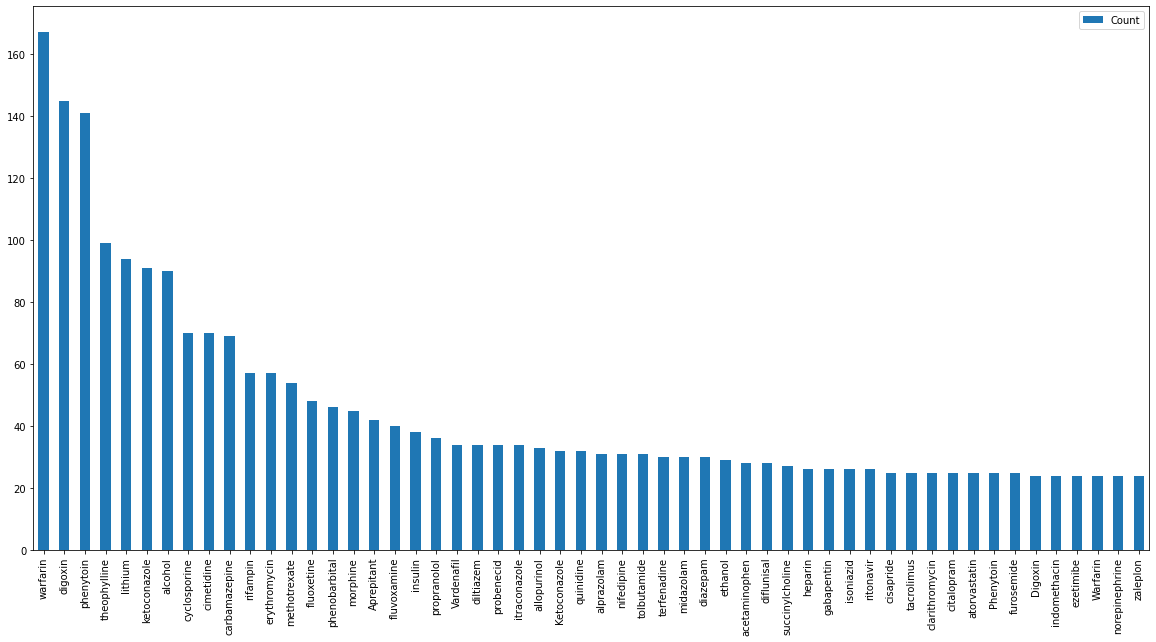

In [13]:
# Analysis of Types
# Visual to cluttered, better from the data frames.

group = df[df["Type"] == "group"]
brand = df[df["Type"] == "brand"]
drug = df[(df["Type"]=='drug') | (df["Type"]== "drug_n")]

group_counts = pd.DataFrame({'Count' : group['Name'].value_counts()})
brand_counts = pd.DataFrame({'Count' : brand['Name'].value_counts()})
drug_counts = pd.DataFrame({'Count' : drug['Name'].value_counts()})

drug_counts['Name'] = drug_counts.index
drug_counts = drug_counts[["Name", "Count"]]
#drug_counts.head(10)

# drug_counts.to_csv(r'/Users/mponsclo/Desktop/Drug_count.csv', index = False)
ax = drug_counts[(drug_counts["Count"] > 23)].plot.bar()

#### Reading drug db

In [15]:
# Using drug database
#resource_path = "/Users/mponsclo/Documents/DataScience/ALHT_Project/resources/HSDB.txt"
resource_path ="../labAHLT/resources/HSDB.txt"
drug_set = set()
with open(resource_path, 'r') as resource_file:
    drugs = resource_file.readlines()
    drug_set = set([d[:-1].lower() for d in drugs])
    #print(drug_set)


In [16]:
def token_type_classifier(word):
        
    threes = ["nol", "lol", "hol", "lam", "pam"]
    fours = ["arin", "oxin", "toin","pine", "tine", "bital", "inol", "pram"]
    fives = ["azole", "idine", "orine", "mycin", "hrine", "exate", "amine", "emide"]

    groups = ["depressants", "steroid", "ceptives", "urates", "amines", "azines", "phenones", 
              "inhib", "coagul", "block", "acids", "agent"]
    
    if word.isupper() & (len(word) >= 4): 
        return True, "brand"  # add word[0].isupper ?
    elif (word[-3:] in threes) | (word[-4:] in fours) | (word[-5:] in fives):
        return True, "drug"
    elif (True in [t in word for t in groups]) | ((word[-1:] == "s") & (word[-2].isupper())) | (word.isupper() & (len(word) < 4)): 
        return True, "group"
    elif word in drug_set:        # Drug Database Checking
        return True, "drug"
    else: 
        return False, ""

In [17]:
print(token_type_classifier("NSAIDs"))
print(token_type_classifier("cimitidine"))
print(token_type_classifier("clozapine"))
print(token_type_classifier("TAXOL"))
print(token_type_classifier("antacids"))

(True, 'group')
(True, 'drug')
(True, 'drug')
(True, 'brand')
(True, 'group')


### Entity Extractor

In [18]:
def extract_entities(s):
    ''' Given a tokenized sentence , identify which tokens (or groups of consecutive tokens) are drugs
    Input - s: A tokenized sentence ( list of triples (word , offsetFrom , offsetTo ) )
    Output - A list of entities. Each entity is a dictionary with the keys 'name ', ' offset ', and 'type '''


    output = []
    for t in s:
        tokenText = t[0] # get the only the text from (text, offsetFrom, offsetTo)
        (is_brand_drug_group, type_text) = token_type_classifier(tokenText)
        
        if is_brand_drug_group:
            offsetFrom = t[1]
            offsetTo = t[2]
            entity = {"name" : tokenText,
                     "offset" : str(offsetFrom) + "-" + str(offsetTo), 
                     "type" : type_text}
            output.append(entity)
    
    return(output)

In [19]:
entity = extract_entities(sent)
for e in entity:
    print("ID" + "|" + e["offset"] + "|" + e["name"] + "|" + e["type"])

ID|0-13|Phenothiazines|group
ID|19-32|butyrophenones|group
ID|80-90|epinephrine|drug


### Main Function

In [27]:
datadir = "/Users/mponsclo/Documents/DataScience/ALHT_Project/train"
datadir = "../labAHLT/data/train"
def main(datadir): #, outfile):
    '''datadir - directory with XML files
       outfile - name for the outputfile'''
    
        # process each file in directory
    for f in listdir(datadir):
        try: 
            # parse XML file, obtaining a DOM tree
            tree = parse(datadir + "/" + f)
            # process each senetence in the file
            sentences = tree.getElementsByTagName("sentence")
            for s in sentences:
                    sid = s.attributes["id"].value        # get sentence id
                    stext = s.attributes["text"].value    # get sentence text
                    # tokenize text
                    tokens = tokenize(stext)
                    # extract entities from tokenized sentence text
                    entities = extract_entities(tokens)

                    # print sentence entities in format requested for evaluation
                    for e in entities:
                        print(sid + " | " + e["offset"] + " | " + e["name"] + " |" + e["type"]) #, file = outfile)
        except:
            pass
        # print performance score
        #evaluator.evaluate("NER", datadir, outfile)

In [28]:
result = main(datadir)
print(result)

DDI-DrugBank.d695.s0 | 27-33 | ZAVESCA |brand
DDI-DrugBank.d695.s1 | 56-62 | ZAVESCA |brand
DDI-DrugBank.d290.s0 | 56-57 | VR |group
DDI-DrugBank.d290.s1 | 62-71 | gentamicin |drug
DDI-DrugBank.d290.s2 | 22-29 | dopamine |drug
DDI-DrugBank.d290.s2 | 35-47 | isoproterenol |drug
DDI-DrugBank.d290.s4 | 23-32 | furosemide |drug
DDI-DrugBank.d290.s5 | 98-103 | agents |group
DDI-DrugBank.d682.s0 | 38-49 | barbiturates |group
DDI-DrugBank.d682.s0 | 52-62 | tolbutamide |drug
DDI-DrugBank.d682.s1 | 66-77 | cyclosporine |drug
DDI-DrugBank.d682.s1 | 120-125 | agents |group
DDI-DrugBank.d682.s1 | 162-169 | warfarin |drug
DDI-DrugBank.d682.s1 | 182-194 | anticoagulant |group
DDI-DrugBank.d682.s1 | 205-216 | methotrexate |drug
DDI-DrugBank.d682.s1 | 205-216 | methotrexate |drug
DDI-DrugBank.d682.s1 | 263-271 | phenytoin |drug
DDI-DrugBank.d682.s1 | 263-271 | phenytoin |drug
DDI-DrugBank.d222.s0 | 5-12 | atropine |drug
DDI-DrugBank.d222.s0 | 5-12 | atropine |drug
DDI-DrugBank.d222.s0 | 5-12 | atropin

DDI-DrugBank.d347.s4 | 67-79 | anticoagulant |group
DDI-DrugBank.d347.s4 | 92-99 | warfarin |drug
DDI-DrugBank.d347.s4 | 172-182 | coagulation |group
DDI-DrugBank.d347.s4 | 92-99 | warfarin |drug
DDI-DrugBank.d347.s6 | 23-34 | gemifloxacin |drug
DDI-DrugBank.d347.s7 | 38-45 | antacids |group
DDI-DrugBank.d347.s7 | 307-313 | FACTIVE |brand
DDI-DrugBank.d347.s8 | 49-55 | FACTIVE |brand
DDI-DrugBank.d88.s0 | 126-137 | capecitabine |drug
DDI-DrugBank.d88.s1 | 55-66 | capecitabine |drug
DDI-DrugBank.d88.s2 | 65-68 | FBAL |brand
DDI-DrugBank.d88.s3 | 0-7 | Coumarin |drug
DDI-DrugBank.d88.s3 | 9-22 | Anticoagulants |group
DDI-DrugBank.d88.s3 | 32-42 | coagulation |group
DDI-DrugBank.d88.s3 | 109-120 | capecitabine |drug
DDI-DrugBank.d88.s3 | 161-174 | anticoagulants |group
DDI-DrugBank.d88.s3 | 184-191 | warfarin |drug
DDI-DrugBank.d88.s3 | 197-209 | phenprocoumon |drug
DDI-DrugBank.d88.s4 | 36-49 | anticoagulants |group
DDI-DrugBank.d88.s4 | 70-81 | capecitabine |drug
DDI-DrugBank.d88.s4 | 1

DDI-MedLine.d42.s12 | 31-35 | agent |group
DDI-DrugBank.d483.s0 | 49-55 | CEFOTAN |brand
DDI-DrugBank.d483.s1 | 3-9 | CEFOTAN |brand
DDI-DrugBank.d483.s2 | 57-63 | CEFOTAN |brand
DDI-DrugBank.d483.s4 | 0-1 | As |group
DDI-DrugBank.d114.s0 | 0-8 | PROLEUKIN |brand
DDI-DrugBank.d114.s2 | 82-93 | indomethacin |drug
DDI-DrugBank.d114.s2 | 159-169 | doxorubicin |drug
DDI-DrugBank.d114.s2 | 194-205 | methotrexate |drug
DDI-DrugBank.d114.s2 | 235-243 | PROLEUKIN |brand
DDI-DrugBank.d114.s3 | 27-35 | PROLEUKIN |brand
DDI-DrugBank.d114.s3 | 76-81 | agents |group
DDI-DrugBank.d114.s4 | 60-68 | PROLEUKIN |brand
DDI-DrugBank.d114.s5 | 121-129 | PROLEUKIN |brand
DDI-DrugBank.d114.s5 | 150-155 | agents |group
DDI-DrugBank.d114.s5 | 172-182 | dacarbazine |drug
DDI-DrugBank.d114.s5 | 199-207 | tamoxifen |drug
DDI-DrugBank.d114.s8 | 161-169 | PROLEUKIN |brand
DDI-DrugBank.d114.s9 | 160-168 | PROLEUKIN |brand
DDI-DrugBank.d114.s10 | 200-205 | agents |group
DDI-DrugBank.d114.s10 | 51-59 | PROLEUKIN |bran

DDI-DrugBank.d0.s0 | 26-32 | alcohol |drug
DDI-DrugBank.d0.s0 | 26-32 | alcohol |drug
DDI-DrugBank.d0.s0 | 108-118 | acamprosate |drug
DDI-DrugBank.d0.s1 | 56-65 | disulfiram |drug
DDI-DrugBank.d0.s1 | 70-77 | diazepam |drug
DDI-DrugBank.d0.s1 | 119-129 | acamprosate |drug
DDI-DrugBank.d0.s2 | 21-30 | naltrexone |drug
DDI-DrugBank.d0.s2 | 76-78 | AUC |group
DDI-DrugBank.d0.s2 | 114-124 | acamprosate |drug
DDI-DrugBank.d0.s4 | 24-33 | naltrexone |drug
DDI-DrugBank.d0.s6 | 47-61 | antidepressants |group
DDI-MedLine.d60.s0 | 0-8 | Phenytoin |drug
DDI-MedLine.d60.s0 | 34-44 | fluvoxamine |drug
DDI-MedLine.d20.s0 | 20-26 | glycine |drug
DDI-MedLine.d20.s1 | 43-49 | glycine |drug
DDI-MedLine.d20.s1 | 119-122 | NMDA |brand
DDI-MedLine.d20.s2 | 30-36 | glycine |drug
DDI-MedLine.d20.s4 | 30-36 | glycine |drug
DDI-MedLine.d20.s6 | 23-29 | glycine |drug
DDI-MedLine.d20.s7 | 65-71 | glycine |drug
DDI-MedLine.d20.s7 | 261-270 | inhibition |group
DDI-MedLine.d36.s0 | 0-12 | Carbamazepine |drug
DDI-M

DDI-DrugBank.d477.s4 | 21-26 | agents |group
DDI-DrugBank.d477.s4 | 76-87 | amphetamines |group
DDI-DrugBank.d477.s5 | 19-24 | agents |group
DDI-DrugBank.d477.s5 | 74-85 | amphetamines |group
DDI-MedLine.d30.s1 | 69-72 | NANM |brand
DDI-MedLine.d30.s1 | 103-115 | phencyclidine |drug
DDI-MedLine.d30.s1 | 118-120 | PCP |group
DDI-MedLine.d30.s1 | 211-212 | FI |group
DDI-MedLine.d30.s1 | 214-215 | FR |group
DDI-MedLine.d30.s2 | 34-36 | PCP |group
DDI-MedLine.d30.s2 | 70-71 | FI |group
DDI-MedLine.d30.s2 | 70-71 | FI |group
DDI-MedLine.d30.s3 | 23-24 | FI |group
DDI-MedLine.d30.s3 | 30-31 | FR |group
DDI-MedLine.d30.s4 | 59-60 | FI |group
DDI-MedLine.d30.s5 | 34-35 | FI |group
DDI-MedLine.d30.s5 | 41-42 | FR |group
DDI-MedLine.d30.s7 | 88-95 | morphine |drug
DDI-MedLine.d30.s7 | 100-101 | FI |group
DDI-MedLine.d30.s7 | 107-108 | FR |group
DDI-MedLine.d30.s8 | 57-59 | PCP |group
DDI-MedLine.d30.s8 | 82-89 | naloxone |drug
DDI-MedLine.d30.s9 | 13-20 | naloxone |drug
DDI-MedLine.d30.s9 | 150-

DDI-DrugBank.d331.s4 | 32-41 | probenecid |drug
DDI-DrugBank.d331.s5 | 28-37 | probenecid |drug
DDI-DrugBank.d331.s5 | 98-103 | sodium |drug
DDI-DrugBank.d331.s5 | 148-157 | inhibitory |group
DDI-DrugBank.d331.s6 | 6-15 | probenecid |drug
DDI-DrugBank.d331.s7 | 70-75 | sodium |drug
DDI-DrugBank.d331.s7 | 124-131 | inhibits |group
DDI-DrugBank.d331.s10 | 2-8 | Digoxin |drug
DDI-DrugBank.d331.s10 | 65-71 | digoxin |drug
DDI-DrugBank.d331.s11 | 2-15 | Anticoagulants |group
DDI-DrugBank.d331.s11 | 91-98 | warfarin |drug
DDI-DrugBank.d376.s0 | 76-78 | CNS |group
DDI-DrugBank.d376.s0 | 81-91 | depressants |group
DDI-DrugBank.d376.s0 | 185-191 | alcohol |drug
DDI-DrugBank.d376.s0 | 76-78 | CNS |group
DDI-DrugBank.d376.s0 | 76-78 | CNS |group
DDI-DrugBank.d376.s0 | 320-329 | ethinamate |drug
DDI-DrugBank.d304.s0 | 33-46 | cholestyramine |drug
DDI-DrugBank.d783.s0 | 8-15 | inhibits |group
DDI-DrugBank.d783.s0 | 78-88 | terfenadine |drug
DDI-DrugBank.d783.s0 | 91-100 | astemizole |drug
DDI-DrugB

DDI-DrugBank.d638.s4 | 66-74 | clonidine |drug
DDI-DrugBank.d638.s5 | 20-34 | methylphenidate |drug
DDI-DrugBank.d638.s5 | 56-64 | clonidine |drug
DDI-DrugBank.d184.s0 | 87-100 | anticoagulants |group
DDI-DrugBank.d184.s0 | 120-132 | carbamazepine |drug
DDI-DrugBank.d184.s0 | 135-147 | corticotropin |drug
DDI-DrugBank.d184.s0 | 150-161 | barbiturates |group
DDI-DrugBank.d184.s0 | 233-235 | CNS |group
DDI-DrugBank.d184.s0 | 238-248 | depressants |group
DDI-DrugBank.d184.s0 | 150-161 | barbiturates |group
DDI-DrugBank.d184.s0 | 233-235 | CNS |group
DDI-DrugBank.d184.s0 | 351-356 | sodium |drug
DDI-DrugBank.d184.s0 | 150-161 | barbiturates |group
DDI-DrugBank.d184.s0 | 488-501 | contraceptives |group
DDI-DrugBank.d184.s0 | 150-161 | barbiturates |group
DDI-DrugBank.d184.s0 | 488-501 | contraceptives |group
DDI-DrugBank.d132.s0 | 5-18 | Anticoagulants |group
DDI-DrugBank.d132.s0 | 97-104 | warfarin |drug
DDI-DrugBank.d132.s0 | 107-119 | acenocoumarol |drug
DDI-DrugBank.d132.s0 | 125-137 | 

DDI-DrugBank.d226.s5 | 58-66 | adenosine |drug
DDI-DrugBank.d226.s5 | 58-66 | adenosine |drug
DDI-DrugBank.d226.s7 | 23-31 | adenosine |drug
DDI-DrugBank.d226.s8 | 0-12 | Carbamazepine |drug
DDI-DrugBank.d226.s8 | 64-68 | block |group
DDI-DrugBank.d226.s8 | 88-93 | agents |group
DDI-DrugBank.d226.s9 | 0-1 | As |group
DDI-DrugBank.d226.s9 | 25-33 | adenosine |drug
DDI-DrugBank.d226.s9 | 107-111 | block |group
DDI-DrugBank.d226.s9 | 148-160 | carbamazepine |drug
DDI-DrugBank.d10.s1 | 29-35 | examine |drug
DDI-DrugBank.d10.s1 | 93-106 | corticosteroid |group
DDI-DrugBank.d10.s1 | 111-114 | ACTH |brand
DDI-DrugBank.d10.s2 | 114-123 | inhibition |group
DDI-DrugBank.d10.s2 | 243-244 | MS |group
DDI-DrugBank.d341.s0 | 63-68 | ENBREL |brand
DDI-DrugBank.d341.s1 | 54-59 | ENBREL |brand
DDI-DrugBank.d341.s1 | 91-102 | methotrexate |drug
DDI-DrugBank.d341.s2 | 41-42 | RA |group
DDI-DrugBank.d341.s2 | 92-97 | ENBREL |brand
DDI-DrugBank.d341.s2 | 92-97 | ENBREL |brand
DDI-DrugBank.d467.s0 | 53-62 |

DDI-DrugBank.d40.s0 | 55-66 | fosphenytoin |drug
DDI-DrugBank.d40.s0 | 58-66 | phenytoin |drug
DDI-DrugBank.d40.s1 | 240-251 | fosphenytoin |drug
DDI-DrugBank.d40.s1 | 243-251 | phenytoin |drug
DDI-DrugBank.d40.s2 | 69-80 | fosphenytoin |drug
DDI-DrugBank.d40.s4 | 44-55 | fosphenytoin |drug
DDI-DrugBank.d40.s4 | 47-55 | phenytoin |drug
DDI-DrugBank.d40.s4 | 73-80 | diazepam |drug
DDI-DrugBank.d40.s4 | 73-80 | diazepam |drug
DDI-DrugBank.d40.s5 | 127-135 | phenytoin |drug
DDI-DrugBank.d40.s6 | 0-8 | Phenytoin |drug
DDI-DrugBank.d40.s7 | 0-8 | Phenytoin |drug
DDI-DrugBank.d40.s7 | 95-104 | inhibitory |group
DDI-DrugBank.d40.s8 | 74-82 | phenytoin |drug
DDI-DrugBank.d40.s9 | 0-8 | Phenytoin |drug
DDI-DrugBank.d40.s10 | 97-105 | phenytoin |drug
DDI-DrugBank.d40.s10 | 137-143 | alcohol |drug
DDI-DrugBank.d40.s10 | 182-197 | chlordiazepoxide |drug
DDI-DrugBank.d40.s10 | 200-209 | cimetidine |drug
DDI-DrugBank.d40.s10 | 212-219 | diazepam |drug
DDI-DrugBank.d40.s10 | 222-230 | dicumarol |drug

DDI-DrugBank.d209.s5 | 16-26 | finasteride |drug
DDI-DrugBank.d209.s5 | 86-87 | LH |group
DDI-DrugBank.d209.s5 | 121-123 | FSH |group
DDI-DrugBank.d209.s6 | 38-48 | finasteride |drug
DDI-DrugBank.d209.s6 | 80-81 | LH |group
DDI-DrugBank.d209.s6 | 87-89 | FSH |group
DDI-DrugBank.d209.s7 | 25-32 | PROPECIA |brand
DDI-DrugBank.d209.s7 | 35-45 | finasteride |drug
DDI-DrugBank.d209.s7 | 132-134 | PSA |group
DDI-DrugBank.d209.s8 | 34-40 | PROSCAR |brand
DDI-DrugBank.d209.s8 | 43-53 | finasteride |drug
DDI-DrugBank.d209.s8 | 124-126 | BPH |group
DDI-DrugBank.d209.s8 | 130-132 | PSA |group
DDI-DrugBank.d209.s9 | 79-81 | PSA |group
DDI-DrugBank.d209.s9 | 116-126 | finasteride |drug
DDI-DrugBank.d61.s0 | 145-159 | corticosteroids |group
DDI-DrugBank.d364.s0 | 57-59 | CYP |group
DDI-DrugBank.d364.s0 | 100-109 | inhibitors |group
DDI-DrugBank.d364.s1 | 0-10 | Fluvoxamine |drug
DDI-DrugBank.d364.s1 | 30-38 | inhibitor |group
DDI-DrugBank.d364.s1 | 59-66 | inhibits |group
DDI-DrugBank.d364.s2 | 64-7

DDI-DrugBank.d521.s6 | 14-18 | water |drug
DDI-DrugBank.d521.s6 | 34-52 | hydrochlorothiazide |drug
DDI-DrugBank.d521.s6 | 55-58 | HCTZ |brand
DDI-DrugBank.d521.s6 | 39-52 | chlorothiazide |drug
DDI-DrugBank.d521.s7 | 4-10 | steroid |group
DDI-DrugBank.d521.s7 | 29-38 | prednisone |drug
DDI-DrugBank.d521.s7 | 70-87 | methylprednisolone |drug
DDI-DrugBank.d521.s7 | 76-87 | prednisolone |drug
DDI-DrugBank.d521.s8 | 4-16 | phenothiazine |drug
DDI-DrugBank.d521.s8 | 26-39 | chlorpromazine |drug
DDI-DrugBank.d521.s8 | 54-65 | fluphenazine |drug
DDI-DrugBank.d521.s8 | 89-104 | prochlorperazine |drug
DDI-DrugBank.d521.s8 | 119-130 | promethazine |drug
DDI-DrugBank.d521.s9 | 2-10 | phenytoin |drug
DDI-DrugBank.d521.s10 | 2-10 | isoniazid |drug
DDI-DrugBank.d521.s11 | 2-9 | rifampin |drug
DDI-DrugBank.d94.s0 | 172-184 | Carbamazepine |drug
DDI-DrugBank.d94.s1 | 29-37 | EQUETROTM |brand
DDI-DrugBank.d94.s2 | 72-84 | Carbamazepine |drug
DDI-DrugBank.d94.s2 | 128-130 | CYP |group
DDI-DrugBank.d94.

DDI-DrugBank.d771.s3 | 34-47 | antihistamines |group
DDI-DrugBank.d771.s3 | 60-68 | meclizine |drug
DDI-DrugBank.d771.s3 | 82-96 | antidepressants |group
DDI-DrugBank.d771.s4 | 29-39 | Scopolamine |drug
DDI-DrugBank.d188.s0 | 29-35 | HEXALEN |brand
DDI-DrugBank.d188.s0 | 41-55 | antidepressants |group
DDI-DrugBank.d188.s0 | 64-66 | MAO |group
DDI-DrugBank.d188.s0 | 68-76 | inhibitor |group
DDI-DrugBank.d188.s0 | 68-76 | inhibitor |group
DDI-DrugBank.d188.s0 | 191-202 | altretamines |group
DDI-DrugBank.d188.s1 | 32-38 | HEXALEN |brand
DDI-DrugBank.d188.s2 | 108-114 | HEXALEN |brand
DDI-DrugBank.d314.s0 | 73-87 | corticosteroids |group
DDI-DrugBank.d466.s0 | 22-33 | Erythromycin |drug
DDI-DrugBank.d466.s0 | 39-50 | Ketoconazole |drug
DDI-DrugBank.d466.s1 | 31-42 | fexofenadine |drug
DDI-DrugBank.d466.s1 | 70-81 | ketoconazole |drug
DDI-DrugBank.d466.s1 | 86-97 | erythromycin |drug
DDI-DrugBank.d466.s1 | 31-42 | fexofenadine |drug
DDI-DrugBank.d466.s2 | 61-72 | erythromycin |drug
DDI-Drug

DDI-DrugBank.d600.s1 | 18-24 | alcohol |drug
DDI-DrugBank.d600.s1 | 36-38 | CNS |group
DDI-DrugBank.d600.s1 | 36-38 | CNS |group
DDI-DrugBank.d600.s1 | 110-120 | methyprylon |drug
DDI-DrugBank.d636.s0 | 39-49 | Mephenytoin |drug
DDI-DrugBank.d636.s1 | 51-61 | Mephenytoin |drug
DDI-DrugBank.d636.s2 | 41-46 | sodium |drug
DDI-DrugBank.d636.s2 | 68-80 | phenobarbital |drug
DDI-DrugBank.d636.s3 | 0-10 | Mephenytoin |drug
DDI-DrugBank.d636.s3 | 75-81 | steroid |group
DDI-DrugBank.d636.s3 | 96-103 | warfarin |drug
DDI-DrugBank.d636.s3 | 178-187 | furosemide |drug
DDI-DrugBank.d636.s3 | 193-204 | theophylline |drug
DDI-DrugBank.d636.s3 | 0-10 | Mephenytoin |drug
DDI-DrugBank.d203.s1 | 13-22 | famotidine |drug
DDI-DrugBank.d203.s2 | 32-39 | warfarin |drug
DDI-DrugBank.d203.s2 | 42-53 | theophylline |drug
DDI-DrugBank.d203.s2 | 56-64 | phenytoin |drug
DDI-DrugBank.d203.s2 | 67-74 | diazepam |drug
DDI-DrugBank.d203.s2 | 77-87 | aminopyrine |drug
DDI-DrugBank.d381.s0 | 0-8 | ERGAMISOL |brand
DDI-

### Others

In [22]:
# Check the process of iteration through XML files in the folder
datadir = "/Users/mponsclo/Documents/DataScience/ALHT_Project/train"
for f in listdir(datadir):
    filename = datadir + "/" + f
    #print(filename)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mponsclo/Documents/DataScience/ALHT_Project/train'

In [23]:
# Construction of the dataframe
tree = ET.parse("/Users/mponsclo/Documents/DataScience/ALHT_Project/train/Estramustine_ddi.xml")
root = tree.getroot()
    
for elem in root:
    for subelem in elem.findall('entity'):    
        # if we know the name of the attribute, access it directly
        # aux_dict = {"text":subelem.get('text'), "type":subelem.get('type')} # as a dict
        
        aux_df = pd.DataFrame({'Name': subelem.get('text'), 'Type': subelem.get('type')}, index=[0])
        df = df.append(aux_df)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mponsclo/Documents/DataScience/ALHT_Project/train/Estramustine_ddi.xml'

In [24]:
# -------- If-elif-else Tests ----------
threes = ["nol", "lol", "hol", "lam", "pam"]
fours = ["arin", "oxin", "toin","pine", "tine", "bital", "inol", "pram"]
fives = ["azole", "idine", "orine", "mycin", "exate", "amine", "emide"]

groups = ["depressants", "steroid", "ceptives", "urates", "amines", "azines", "inhib", "coagul", "block", "acids"]

prove_group = "NSAIDs"
prove_group_2 = "SSRIs"
prove_group_3 = "antacids"

prove_drug = "alcohol"
prove_drug_2 = "cimitidine"
prove_drug_3 = "clozapine"

prove_brand = "TAXOL"
prove_brand_2 = "VIOXX"

#if (prove_brand_2.isupper() | prove_brand_2[0].isupper()) & (len(prove_brand) >= 4): 
#    print("brand")
#else:
#    print("No")

#if prove_drug_3[-4:] in fours: 
#    print("drug")
#else:
#    print("False")

#if (True in [t in prove_group_3 for t in groups]) | (prove_group_3.isupper() & len(prove_group_3) < 4): print("group")

In [25]:
sent_1 = "Activation of an effector immediate-early gene arc by methamphetamine"
for t in sent:
    (is_brand_drug_group, type_text) = token_type_classifier(t[0])
    #print(is_brand_drug_group, type_text)
    
    if is_brand_drug_group:
        print(t, type_text)

('Phenothiazines', 0, 13) group
('butyrophenones', 19, 32) group
('epinephrine', 80, 90) drug


In [26]:
# ------ Drug db tests -----------
def old_token_type_classifier(word):
    
    threes = ["nol", "lol", "hol", "lam", "pam"]
    fours = ["arin", "oxin", "toin","pine", "tine", "bital", "inol", "pram"]
    fives = ["azole", "idine", "orine", "mycin", "exate", "amine", "emide"]

    groups = ["depressants", "steroid", "ceptives", "urates", "amines", "azines", 
              "inhib", "coagul", "block", "acids", "agent"]
    
    if word.isupper() & (len(word) >= 4): 
        return True, "brand"  # add word[0].isupper ?
    elif (word[-3:] in threes) | (word[-4:] in fours) | (word[-5:] in fives):
        return True, "drug"
    elif (True in [t in word for t in groups]) | ((word[-1:] == "s") & (word[-2].isupper())) | (word.isupper() & (len(word) < 4)): 
        return True, "group"
    else: 
        return False, ""
    
def with_db_type_classifier(word):
    
    threes = ["nol", "lol", "hol", "lam", "pam"]
    fours = ["arin", "oxin", "toin","pine", "tine", "bital", "inol", "pram"]
    fives = ["azole", "idine", "orine", "mycin", "exate", "amine", "emide"]

    groups = ["depressants", "steroid", "ceptives", "urates", "amines", "azines", 
              "inhib", "coagul", "block", "acids", "agent"]
    
    if word.isupper() & (len(word) >= 4): 
        return True, "brand"  # add word[0].isupper ?
    elif (word[-3:] in threes) | (word[-4:] in fours) | (word[-5:] in fives):
        return True, "drug"
    elif (True in [t in word for t in groups]) | ((word[-1:] == "s") & (word[-2].isupper())) | (word.isupper() & (len(word) < 4)): 
        return True, "group"
    # added 
    elif word in drug_set:
        return True, "drug"
    else: 
        return False, ""
    
sent = """Activation of an effector immediate-early gene arc by methamphetamine.
Interactions between treatments with coumaphos, bishydroxycoumarin (an anticoagulant),
trichlorfon (an organophosphorous compound), and phenobarbital sodium (an inducer of microsomal enzymes)
were investigated in sheep. Maximal exercise testing, a maneuver often applied to cardiac patients,
does not significantly alter the serum digoxin level."""
no_db_checking_count = 0
with_db_checking_count = 0
sent_1 = tokenize(sent)
# without checking db:
for t in sent_1:
    (is_brand_drug_group, type_text) = old_token_type_classifier(t[0])
    (is_brand_drug_group_with_db, type_text) = with_db_type_classifier(t[0])
    
    if is_brand_drug_group:
        no_db_checking_count += 1
    if is_brand_drug_group_with_db:
        with_db_checking_count += 1

print(no_db_checking_count, with_db_checking_count)

4 8


In [ ]:
# --- multi-token tests --
